In [70]:
using Catalyst
using ColorSchemes
using Dictionaries
using DifferentialEquations
using Formatting
using IterTools
using LaTeXStrings
using LinearAlgebra
using NNlib
using Noise
using Plots
using Random
using ReactionNetworkImporters
using Statistics

include("utils.jl")
include("datasets.jl")
Random.seed!(1224)

TaskLocalRNG()

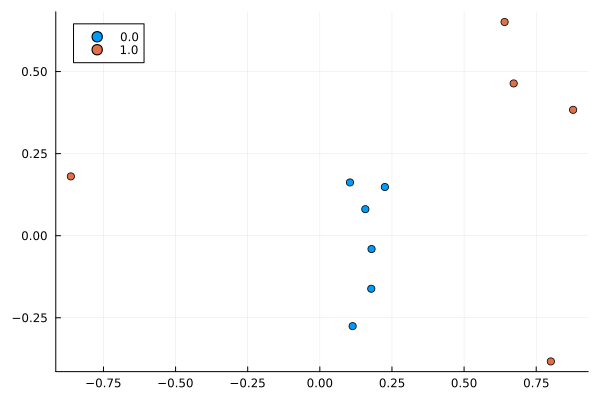

In [71]:
train = create_annular_rings_dataset(10)
val = create_annular_rings_dataset(10)

x = getindex.(train, 1)
y = getindex.(train, 2)
labels = getindex.(train, 3)

scatter(x, y, group=labels)

In [72]:
function create_params(; dims=3, t0=0.0, t1=1.0, h=0.1)
    params = []

    push!(params, Float32(dims))

    theta = rand(Normal(0.5, 0.1), dims^2)
    append!(params, theta)
    beta = ones(dims)*0.1
    append!(params, beta)

    w = randn(dims)
    append!(params, w)

    push!(params, h)

    push!(params, t0)
    push!(params, t1)

    for i in eachindex(params)
        params = 1.0 * params
    end

    return params
end

params = create_params(h=0.5)

19-element Vector{Float64}:
  3.0
  0.6720708079272535
  0.6465159792555629
  0.5236150112148112
  0.33336813877355037
  0.28825036087336847
  0.5555179732793722
  0.5202474581686339
  0.3506929435117095
  0.5488790531764756
  0.1
  0.1
  0.1
  1.388841368577774
  1.1903178532994623
 -0.435784071139857
  0.5
  0.0
  1.0

In [81]:
function f(u, xAndp, t)
    x = xAndp[1:3]
    p = xAndp[4:end]
    dims, theta, beta, w, h, _, _ = sequester_params(p)
    hvec = [h, h, h]
    fmat = - u.*u 
#     fmat = hvec + (theta * x + beta) .* u - u .* u
    # fmat = theta*u
    @assert length(fmat) == length(u)
    return fmat
end

function forward!(du, u, xAndp, t)
    fmat = f(u, xAndp, t)
    for i in eachindex(fmat)
        du[i] = fmat[i] 
    end
end

# Calculates the final hidden state of the neural ode
function forward_node(u0, xAndp, tspan)
    prob = ODEProblem(forward!, u0, tspan, xAndp)
    sol = solve(prob, Tsit5(), reltol=1e-8, abstol=1e-12, save_on=false)
    return sol
end

forward_node (generic function with 1 method)

In [82]:
function backward!(du, u, sAndp, t)
    func = -f(u, sAndp, t)
    for i in eachindex(func)
        du[i] = func[i]
    end
end

function backward_node(s0, sAndp, tspan)
    prob = ODEProblem(backward!, s0, tspan, sAndp)
    sol = solve(prob, Tsit5(), reltol=1e-8, abstol=1e-12, save_on=false)
    return sol
end

backward_node (generic function with 1 method)

In [83]:
DIMS = 3
tspan = (0.0, 1.0)
rtspan = reverse(tspan)
fsol = nothing
bsol = nothing
idealz = []
odez = []
idealx = []
odex = []
for trindex in eachindex(train)
    x = train[trindex][1:2]
    y = train[trindex][3]
    append!(x, 0.1)

    println("ODE | Input | ", x)
    dims, theta, beta, w, h, t0, t1 = sequester_params(params)
    reluval = relu.(x + theta*x + beta)
    println("ODE | Ideal Before ReLU | ",  x + theta*x + beta)
    println("ODE | Ideal ReLU | Val1 | ", reluval)
    xAndp = []
    append!(xAndp, x)
    append!(xAndp, params)

    fsol = forward_node(x, xAndp, tspan)
    println("ODE | z @ t=T | ", fsol[end])
    z = fsol[end]

    zAndp = []
    append!(zAndp, z)
    append!(zAndp, params)
    bsol = backward_node(z, zAndp, tspan)
    println("ODE | Input | ", x)
    println("ODE | z @ t=0 | ", bsol[end])
    println("===========================")

    ## Tracking
    push!(idealx, x)
    push!(idealz, reluval)
    push!(odex, bsol[end])
    push!(odez, fsol[end])
    # break
end
nothing

ODE | Input | [0.11364800482988358, -0.27549228072166443, 0.1]
ODE | Ideal Before ReLU | [0.16427885072858966, -0.16146460888410855, 0.21739979211529648]
ODE | Ideal ReLU | Val1 | [0.16427885072858966, 0.0, 0.21739979211529648]
ODE | z @ t=T | [0.10205020288010608, -0.3802475437814665, 0.09090909090910271]
ODE | Input | [0.11364800482988358, -0.27549228072166443, 0.1]
ODE | z @ t=0 | [0.11364800482993381, -0.2754922807863667, 0.10000000000002131]
ODE | Input | [0.15772421658039093, 0.08079907298088074, 0.1]
ODE | Ideal Before ReLU | [0.4683254511599243, 0.31222146077471175, 0.36527919282191756]
ODE | Ideal ReLU | Val1 | [0.4683254511599243, 0.31222146077471175, 0.36527919282191756]
ODE | z @ t=T | [0.1362364320679371, 0.07475864385975252, 0.09090909090928506]
ODE | Input | [0.15772421658039093, 0.08079907298088074, 0.1]
ODE | z @ t=0 | [0.15772421658658753, 0.08079907298094587, 0.10000000000028068]
ODE | Input | [0.17921824753284454, -0.04057860001921654, 0.1]
ODE | Ideal Before ReLU |

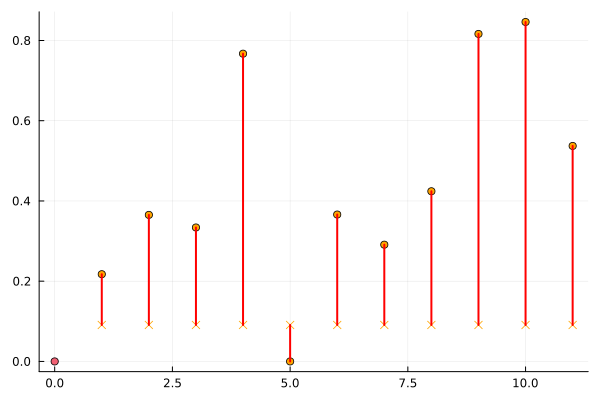

In [84]:
plot()
xplot = [i for i in 1:length(train)]
yideals = [idealx, idealz]
yodes = [odex, odez]
J = 3 # 1, 2, 3 are for first, second, third coordinates
for yi in [2] # 1 is for x , 2 is for z
    yideal = yideals[yi]
    yode = yodes[yi]
    colors = ["blue", "green", "orange"]
    markershapes = [:circle, :rect]
    g = scatter!(xplot, getindex.(yideal, J), mc=colors[J],  markershape=:circle) 
    g = scatter!(xplot, getindex.(yode, J), mc=colors[J], markershape=:xcross)
    yidealJ = getindex.(yideal, J)
    yodeJ = getindex.(yode, J)
    for xi in eachindex(xplot)
        plot!([xi, xi], [yidealJ[xi], yodeJ[xi]], linewidth=2, color=:red)
    end

    
end
scatter!([0], [0], legend=:none)

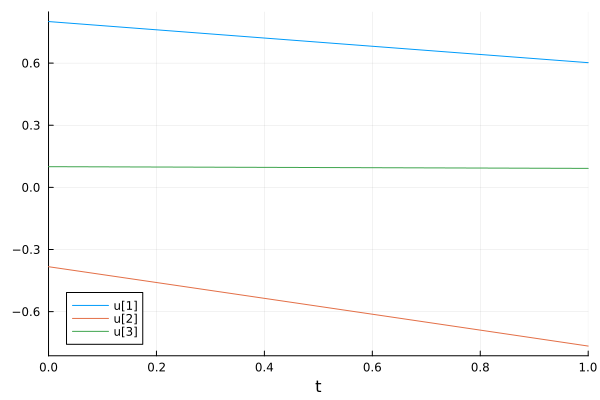

In [85]:
plot(fsol)

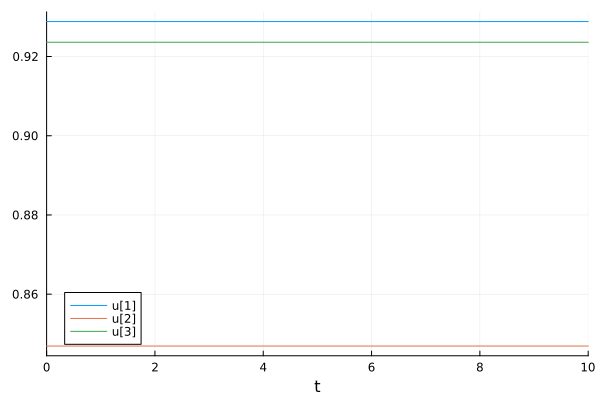

In [53]:
plot(bsol)

In [12]:
params

19-element Vector{Float64}:
  3.0
  1.0051105412506975
  0.9457003922474211
  1.2468537845343666
  0.5525402311145169
  1.0930934353079695
  0.878585875709018
  1.2694906743546757
  1.3055274565840618
  1.077519600009089
  0.1
  0.1
  0.1
  0.789234359882783
  0.3255546880870426
 -1.1643838938969744
  0.5
  0.0
  1.0

In [13]:
a = [1, 2, 3]
b = [2, 4, 6]
a./b

3-element Vector{Float64}:
 0.5
 0.5
 0.5

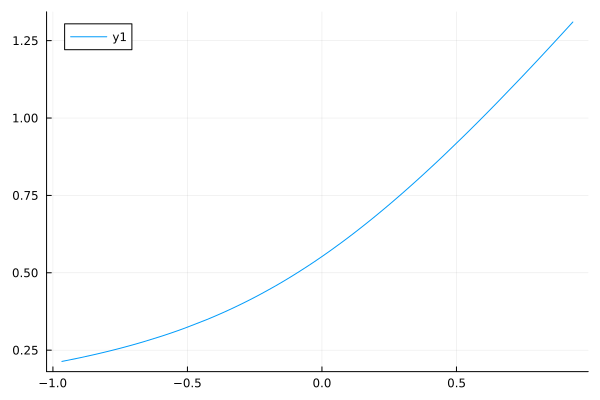

In [14]:
dims, theta, beta, w, h, _, _ = sequester_params(params)
index = 2
xplot = sort!(rand(Uniform(-1, 1), 100))
yplot = []
for i in eachindex(xplot)
    x = zeros(dims)
    x[index] = xplot[i]
    rho = theta*x + beta
    rhoindex = rho[index]
    push!(yplot, (rhoindex + sqrt(rhoindex^2 + 1))/2)
end
plot(xplot, yplot)


## Searching for more simpler activation functions with ODEs

In [ ]:
function fx(u, p, t)